# Case Study 4: Computational Methods in Finance

# Charles Laferte - cl4249

In [1]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs, minimize
from scipy.stats import norm

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Simulate the market data with Heston Stochastic Volatility Model

Let's set the parameters we will consider for the Heston model:

In [2]:
'''
kappa  = params[0];
theta  = params[1];
sigma  = params[2];
rho    = params[3];
v0     = params[4];
'''
S0 = 4100
r = 0.0485
mu = r
params = [0.02, 1.5, 0.05, 0.18, 0.5, 0.04]


In [3]:
N = 10*252 # 10 years * 252 trading day per year
T = 10
dt = T/N

In [4]:
def heston_simulated_prices(params, N, T, S0, r, mu, plot = False):
    kappa  = params[0]
    theta  = params[1]
    sigma  = params[2]
    rho    = params[3]
    v0     = params[4]
    
    # Define discretization parameters
    dt = T/N        # time increment
    M = 1           # number of simulations
    print('T:',T,'  N:', N, '  dt:', dt)
    print(v0)

    # Generate random numbers
    Z1 = norm.rvs(size=(N, M))
    Z2 = rho*Z1 + np.sqrt(1-rho**2)*norm.rvs(size=(N, M))

    # Define arrays to store stock price and volatility paths
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))

    # Set initial values
    S[0,:] = S0
    v[0,:] = v0 #theta
    print(v0)
    
    # Calculate paths
    for i in range(N):
        v[i+1,:] = np.maximum(0, v[i,:] + kappa*(theta-v[i,:])*dt + sigma*np.sqrt(v[i,:])*np.sqrt(dt)*Z1[i,:])
        #print(v[i+1,:])
        S[i+1,:] = S[i,:] * np.exp((mu - 0.5*v[i,:])*dt + np.sqrt(v[i,:])*np.sqrt(dt)*Z2[i,:])
        #print(S[i+1,:])
    
    # Plot results
    if plot == True:
        plt.plot(S)
        plt.title('Simulated Heston Model Stock Price Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.show()
    
        plt.plot(v)
        plt.title('Simulated Heston Model volatility Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Volatility')
        plt.show()
        
    # Reshaping the outputs
    y = np.log(S)
    S = S.T
    S = S[0]
    v = v.T
    v = v[0]
    y = y.T
    y = y[0]
    
    return S, v, y
    

[1.5  0.05 0.18 0.5  0.04]
T: 10   N: 500   dt: 0.02
0.04
0.04


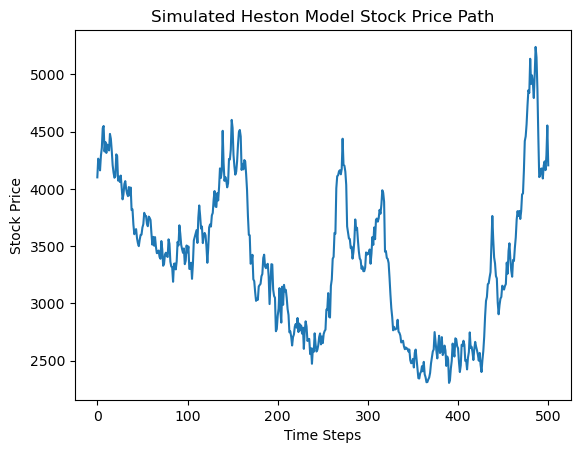

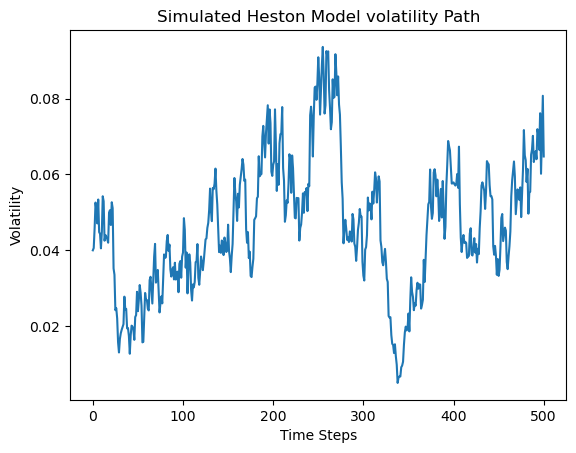

In [5]:
#prices, v_, y = heston_simulated_prices(params, N, T, S0, r, mu, plot = True)
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 500
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

## 1. Extended Kalman Filter

In [127]:
def ext_Kalman_filter(params):
    
    global y_KF, v_KF
    
    mu     = params[0]
    kappa  = params[1]
    theta  = params[2]
    lambda_= params[3]
    rho    = params[4]
    v_0    = params[5]
    
    dt = T/N 
        
        
    F = np.matrix([[1, -1/2*dt],[0, 1-kappa*dt]])
    U = np.matrix([[np.sqrt(v_0*dt), 0],[0, lambda_*np.sqrt(v_0*dt)]])
    Q = np.matrix([[1, rho],[rho, 1]])
    H = np.matrix([1,0])
    P = np.matrix([[0.03, 0],[0, 0.03]])
    I = np.identity(2)
    
    x_update = np.matrix([np.log(S0), v_0]).T
    
    y_KF = np.zeros(N)
    v_KF = np.zeros(N)
    
    y_KF[0] = np.log(S0)
    v_KF[0] = v_0
    
    func_obj = 0
    for i in range(1, N):
        
        x_pred = np.matrix([0,0], dtype=np.float64).T
        x_pred[0,0] = x_update[0,0] + (mu-1/2*x_update[1,0])*dt
        x_pred[1,0] = x_update[1,0] + kappa*(theta-x_update[1,0])*dt
        
        P_pred = F@P@F.T + U@Q@U.T
        
        A = H@P_pred@H.T
        
        A = A[0,0]
        
        err = y[i] - x_pred[0,0]
        
        func_obj += np.log(abs(A)) + err**2/A
        
        # Measurement

        K = P_pred*H.T/A

        x_update = x_pred + K*err
        
        # check if volatility not negative
        x_update[1,0] = max(1e-5, x_update[1,0]) 
        
        vk = x_update[1,0]
        
        U = np.matrix([[np.sqrt(vk*dt), 0],[0, lambda_*np.sqrt(vk*dt)]])
        
        P = (I-K*H)*P_pred
        
        y_KF[i] = x_update[0,0]
        v_KF[i] = x_update[1,0]
    print(params)
    
    return func_obj/N
    

In [128]:
def Extended_Kalman_Filter(params, S0, y, N, T):
    mu, kappa, theta, lbda, rho, v0 = params
    global y_EKF, v_EKF
    dt = T / N
        
    P = np.array([[0.01, 0], [0, 0.01]])
    I = np.identity(2)
    F = np.array([[1, -1/2*dt], [0, 1-kappa*dt]])
    U = np.array([[np.sqrt(v0*dt), 0], [0, lbda*np.sqrt(v0*dt)]])
    Q = np.array([[1, rho], [rho, 1]])
    H = np.array([1, 0])
    
    x_update = np.array([[np.log(S0), v0]]).T
    
    y_EKF = np.zeros(N)
    v_EKF = np.zeros(N)
    
    y_EKF[0] = np.log(S0)
    v_EKF[0] = v0
    
    func_obj = 0
    for i in range(1, N):
        x_pred = np.zeros((2, 1), dtype=np.float64)
        x_pred[0, 0] = x_update[0, 0] + (mu - 1/2*x_update[1, 0]) * dt
        x_pred[1, 0] = x_update[1, 0] + kappa * (theta - x_update[1, 0]) * dt
        
        P_pred = F * P * F.T + U * Q * U.T
        
        A = H * P_pred * H.T
        A = A[0, 0]
        
        err = y[i] - x_pred[0, 0]
        
        func_obj += np.log(abs(A)) + err**2 / A
        
        K = P_pred * H.T / A
        
        x_update = x_pred + K * err
        
        # check if volatility not negative
        x_update[1, 0] = max(1e-5, x_update[1, 0]) 
        
        vk = x_update[1, 0]
        
        U = np.array([[np.sqrt(vk*dt), 0], [0, lbda*np.sqrt(vk*dt)]])
        
        P = (I - K * H) * P_pred
        
        y_EKF[i] = x_update[0, 0]
        v_EKF[i] = x_update[1, 0]
        
    print(params)
        
    return func_obj / N#, y_EKF, v_EKF


In [ ]:
def opt_param_research():
    def callback(x):
        print("Current parameter vector:", x)

    N = 10 * 252  # 10 years * 252 trading days per year
    T = 10
    S0 = 4100
    r = 0.0485
    mu = r
    params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
    prices, v_, y = heston_simulated_prices(params, N, T, S0, r, mu, plot=True)
    
    params_0 = [0.03, 1.3, 0.07, 0.3, 0.6, 0.06]
    
    #constraint1 = {'type': 'ineq', 'fun': lambda x: x}#[0] - 1}
    #constraint2 = {'type': 'ineq', 'fun': lambda x: 2 - x[0]}
    #constraints = [constraint1]#, constraint2]
    bounds = [(0.000001, 2)]*6
    bounds[1] = (0.5,2)
    bounds[4] = (-1,1)
    xopt = minimize(Extended_Kalman_Filter, params_0, args=(S0, y, N, T), callback=callback,bounds=bounds, method='Nelder-Mead')
    print(80 * '=')
    print('Optimal parameter set:')
    print(xopt)
    print(80 * '=')

    return xopt

# Run the optimization
result_EKF = opt_param_research()

[1.5  0.05 0.18 0.5  0.04]
T: 10   N: 2520   dt: 0.003968253968253968
0.04
0.04


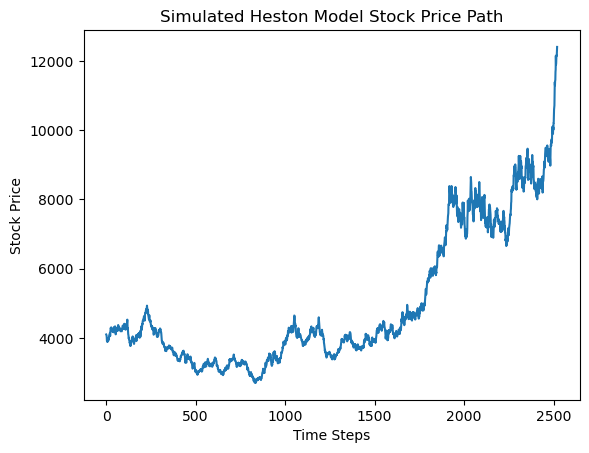

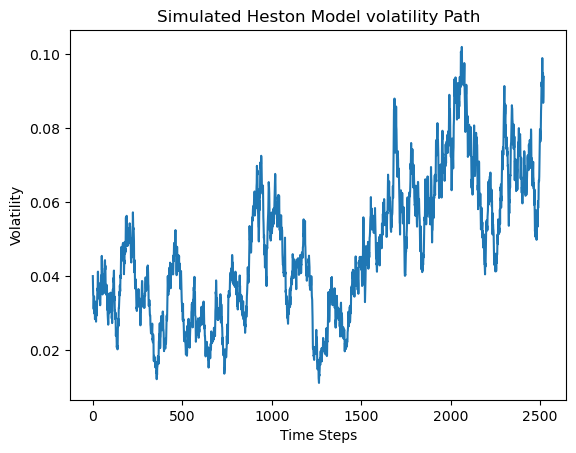

0.003968253968253968


In [73]:
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 10*252 # 10 years * 252 trading day per year
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

dt = T/N
print(dt)

Set the initial guess for the optimization : 

In [118]:
# true : [0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]
params_0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05]
params_0 = [0.02, 1.5, 0.05, 0.18, 0.5, 0.1]
params_0 = [0.03, 1.3, 0.07, 0.1, 0.6, 0.06]

Use the Nelder-Mead algorithm to minimize the function

In [129]:
def opt_param_research():
    
    def callback(x):
        print("Current parameter vector:", x)

    
    #constraint1 = {'type': 'ineq', 'fun': lambda x: x}#[0] - 1}
    #constraint2 = {'type': 'ineq', 'fun': lambda x: 2 - x[0]}
    #constraints = [constraint1]#, constraint2]
    bounds = [(0.000001, 30)]*6
    #bounds[1] = (0,2)
    #bounds[4] = (-1,1)
    xopt = minimize(ext_Kalman_filter, params_0, callback=callback, method='Nelder-Mead',options={'maxiter': 200},bounds=bounds)
    #result_2 = minimize(obj_function_ext_KF_m, params_0, bounds=bounds, callback=callback)# method='Nelder-Mead',
    #xopt, fopt, _, _, _ = fmin(ext_Kalman_filter, params_0, maxiter=100, callback=callback, disp=True, retall=False, full_output=True)

    #result = fmin(ext_Kalman_filter, params_0, callback=callback)
    print(80*'=')
    print('Optimal parameter set:')
    print(xopt)
    print(80*'=')
    
    return xopt

In [130]:
result_EKF = opt_param_research()

[0.03 1.3  0.07 0.3  0.6  0.06]
[0.0315 1.3    0.07   0.3    0.6    0.06  ]
[0.03  1.365 0.07  0.3   0.6   0.06 ]
[0.03   1.3    0.0735 0.3    0.6    0.06  ]
[0.03  1.3   0.07  0.315 0.6   0.06 ]
[0.03 1.3  0.07 0.3  0.63 0.06]
[0.03  1.3   0.07  0.3   0.6   0.063]
[0.0305     1.32166667 0.0665     0.305      0.61       0.061     ]
[0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
[0.03075    1.3325     0.06766667 0.3075     0.615      0.0575    ]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
[0.031      1.34333333 0.06688889 0.31       0.58       0.05966667]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
[0.03133333 1.35777778 0.06585185 0.29333333 0.60333333 0.05955556]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
[0.03177778 1.37703704 0.06446914 0.30611111 0.60444444 0.05940741]
Current parameter vector: [0.03075 1.332

[0.03825556 1.53554795 0.04354437 0.33732441 0.42388027 0.06133317]
Current parameter vector: [0.0370862  1.59593334 0.04200714 0.33837802 0.42445865 0.05932847]
[0.03736268 1.59046697 0.04178428 0.33746494 0.41152517 0.05970448]
Current parameter vector: [0.0370862  1.59593334 0.04200714 0.33837802 0.42445865 0.05932847]
[0.03783386 1.56127226 0.04036151 0.3458292  0.40499542 0.06126392]
Current parameter vector: [0.0370862  1.59593334 0.04200714 0.33837802 0.42445865 0.05932847]
[0.03658148 1.57200475 0.0390945  0.33842618 0.42462627 0.06216194]
[0.03783704 1.54466215 0.0424319  0.33759985 0.42406677 0.06154036]
Current parameter vector: [0.0370862  1.59593334 0.04200714 0.33837802 0.42445865 0.05932847]
[0.0380435  1.6472499  0.0400741  0.3453799  0.36304948 0.06044245]
[0.03730169 1.52285696 0.04191718 0.33547846 0.44334448 0.06211655]
Current parameter vector: [0.0370862  1.59593334 0.04200714 0.33837802 0.42445865 0.05932847]
[0.03793378 1.56287775 0.04241711 0.3384692  0.4338511

[0.04329352 1.64467395 0.04403991 0.35689344 0.41277279 0.0382552 ]
Current parameter vector: [0.04213796 1.74192217 0.04319361 0.35670838 0.40229715 0.03380981]
[0.04312509 1.69392511 0.04328289 0.36102866 0.40056137 0.03499915]
[0.04462863 1.67364771 0.04312009 0.36413856 0.38691535 0.03470359]
Current parameter vector: [0.04462863 1.67364771 0.04312009 0.36413856 0.38691535 0.03470359]
[0.04401853 1.72553515 0.04460547 0.36269155 0.40046433 0.02965499]
[0.04143632 1.70305702 0.04302221 0.35759347 0.41338484 0.03694629]
Current parameter vector: [0.04462863 1.67364771 0.04312009 0.36413856 0.38691535 0.03470359]
[0.04318096 1.65531071 0.04306146 0.35890513 0.40238591 0.03819345]
Current parameter vector: [0.04462863 1.67364771 0.04312009 0.36413856 0.38691535 0.03470359]
[0.04126886 1.76428818 0.04247981 0.36184102 0.4013246  0.03228294]
Current parameter vector: [0.04462863 1.67364771 0.04312009 0.36413856 0.38691535 0.03470359]
[0.04424597 1.67939524 0.04302141 0.35793061 0.3969147

[0.06934382 1.02365284 0.04162472 0.41600059 0.39089931 0.0267709 ]
[0.07350527 0.8420388  0.04215722 0.43025512 0.36261528 0.03315642]
Current parameter vector: [0.07987097 0.71476566 0.04208706 0.43471547 0.40196719 0.0258032 ]
[0.07936074 0.77419265 0.0419599  0.43522597 0.3703533  0.02552896]
Current parameter vector: [0.07987097 0.71476566 0.04208706 0.43471547 0.40196719 0.0258032 ]
[0.07583871 0.77098204 0.04227126 0.422812   0.36517363 0.03604781]
Current parameter vector: [0.07987097 0.71476566 0.04208706 0.43471547 0.40196719 0.0258032 ]
[0.07906157 0.73137293 0.04168092 0.4379976  0.38704315 0.02656826]
Current parameter vector: [0.07987097 0.71476566 0.04208706 0.43471547 0.40196719 0.0258032 ]
[0.07540699 0.86995565 0.04156271 0.43906133 0.38506694 0.02242444]
[0.07573078 0.79572544 0.04209412 0.42687433 0.37014696 0.03264196]
Current parameter vector: [0.07987097 0.71476566 0.04208706 0.43471547 0.40196719 0.0258032 ]
[0.08411493 0.60114875 0.04151604 0.44473406 0.3828605

[0.08476114 0.602858   0.04321619 0.44445949 0.42331987 0.02076808]
Current parameter vector: [0.08423129 0.61585389 0.04316945 0.44269695 0.41989107 0.02156168]
[0.08480244 0.6128702  0.04303543 0.44215644 0.42214254 0.0206092 ]
[0.08345671 0.63140667 0.04315874 0.44088299 0.41533009 0.02275214]
Current parameter vector: [0.08423129 0.61585389 0.04316945 0.44269695 0.41989107 0.02156168]
[0.08360378 0.63937468 0.04324001 0.44170939 0.41216255 0.02207316]
[0.08339603 0.65098082 0.04334194 0.44211414 0.40768785 0.02201478]
Current parameter vector: [0.08360378 0.63937468 0.04324001 0.44170939 0.41216255 0.02207316]
[0.08434254 0.62614528 0.04349032 0.44168929 0.41607179 0.02138533]
[0.08360664 0.63045198 0.04304711 0.44126034 0.41597496 0.02235377]
Current parameter vector: [0.08360378 0.63937468 0.04324001 0.44170939 0.41216255 0.02207316]
[0.08464244 0.61714943 0.0430773  0.44271285 0.4177079  0.02096602]
[0.08355891 0.63299401 0.04320388 0.44096729 0.41546973 0.02242428]
Current para

In [121]:
print(result_EKF.x)

[0.07947342 0.60217039 0.0431221  0.48609422 0.42086022 0.01930178]


In [94]:
print(params)

[0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]


## Plotting the results:

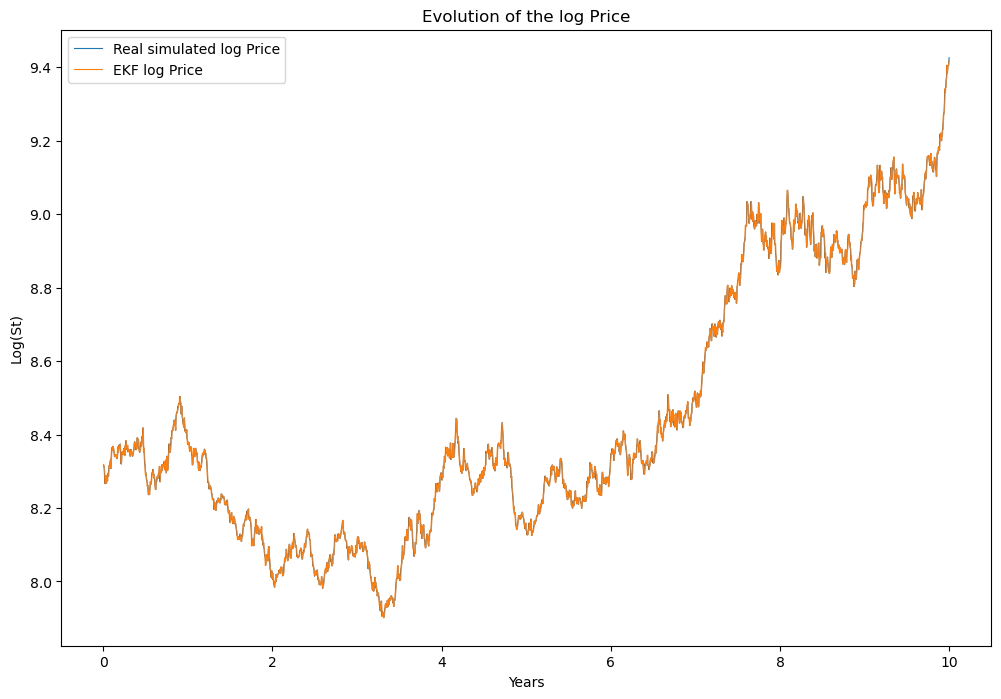

In [122]:
plt.figure(figsize=(12,8))
years = np.arange(y.shape[-1]) * dt
plt.plot(years[1:], y[1:], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years[1:], y_KF, label = 'EKF log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.legend()
plt.show()

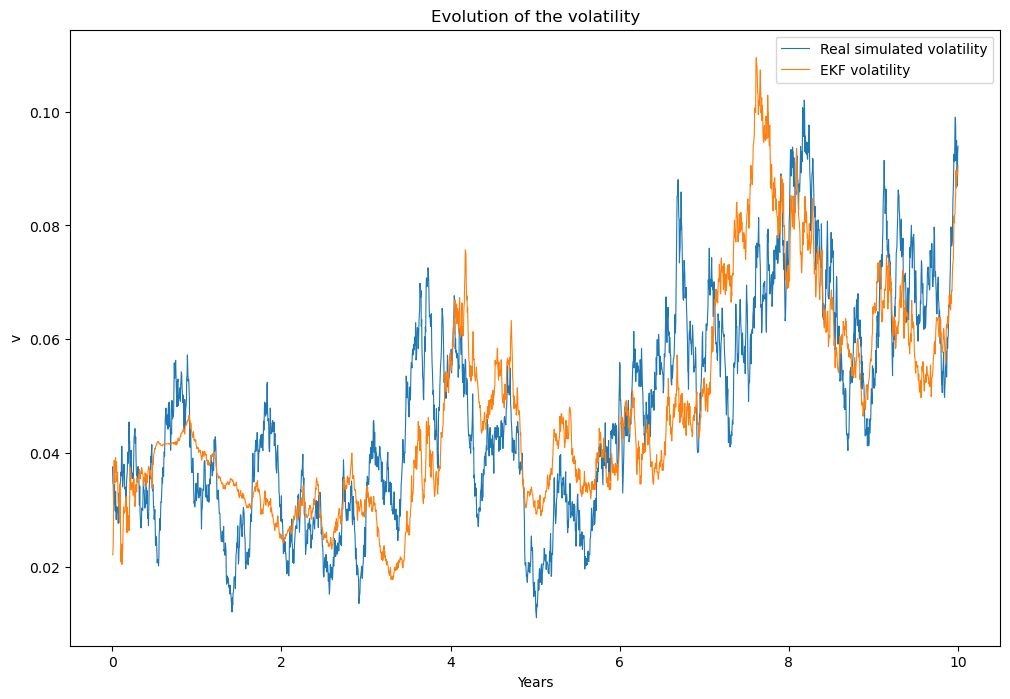

In [123]:
plt.figure(figsize=(12,8))
plt.plot(years[1:], v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v_KF, label = 'EKF volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.legend()
plt.show()

## 2. Particle Filtering

### 2.1 Preparing the different functions

In [44]:
def proposal_distribution(N, x_prev, dy, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    return norm.rvs(m, s, N)

In [45]:
def likelihood(y, x, x_prev, y_prev, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x_prev*dt)
    
    return norm.pdf(y,m,s)

In [46]:
def transition(x, x_prev, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
        s = 1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt)
        
        return norm.pdf(x, m, s)

In [47]:
def proposal(x, x_prev, dy, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
        s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
        
        return norm.pdf(x, m, s)

In [48]:
def parameter_states_init(N, bounds):
    # initialize param states
    params_states = np.zeros((len(bounds), N))
    b0, b1, b2, b3, b4 = bounds
    params_states[0] = np.random.rand(N)*(b0[1]-b0[0])+b0[0]
    params_states[1] = np.random.rand(N)*(b1[1]-b1[0])+b1[0]
    params_states[2] = np.random.rand(N)*(b2[1]-b2[0])+b2[0]
    params_states[3] = np.random.rand(N)*(b3[1]-b3[0])+b3[0]
    params_states[4] = np.random.rand(N)*(b4[1]-b4[0])+b4[0]
    return params_states

In [49]:
def resample_state(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. 
    indexes = np.searchsorted(cumulative_sum, np.random.rand(N))
    particles[:] = particles[indexes]
    new_weights = np.ones(len(weights)) / len(weights)
    return particles, new_weights

In [50]:
def resample(x_pred, weights, params_states):
        params_states[0], _ = resample_state(params_states[0], weights)
        params_states[1], _ = resample_state(params_states[1], weights)
        params_states[2], _ = resample_state(params_states[2], weights)
        params_states[3], _ = resample_state(params_states[3], weights)
        params_states[4], _ = resample_state(params_states[4], weights)
        x_pred, weights = resample_state(x_pred, weights)
        return x_pred, weights, params_states

In [51]:
def prediction_density(y, y_prev, x, mu):
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x*dt)
    return norm.pdf(y, m, s)

def prediction_density_v(v, x_prev, dy, lambda_,rho, theta, kappa):#(v, v_prev, x, mu, params):
    #mu, kappa, theta, lambda_, rho = params
    #m = v_prev + (mu-1/2*x)*dt
    #s = np.sqrt(x*dt)
    #return norm.pdf(y, m, s) # cf equation 8.43
    #proposal
    #m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    #s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    '''print('k', kappa)
    print('t', theta)
    print('x',x_prev)'''
    #transition
    m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
    #print('m',m)
    s = (1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt))
        
        
    # last trial=
    #delta = kappa*theta- rho*lambda_*mu-(kappa-0.5*rho*lambda_)*x_prev
    #m = x_prev+delta*dt+rho*y_prev
    return norm.pdf(v, m, s)

In [52]:
def predict(x_pred, particles, y_prev, mu):
    
    y_hat = y_prev + (mu-1/2*x_pred)*dt + np.sqrt(particles*dt)*norm.rvs()
    #print('yhat', y_hat)
    py_hat = np.array([np.mean(prediction_density(y_hat[k], y_prev, x_pred, mu)) for k in range(len(y_hat))])
    
    py_hat = py_hat/sum(py_hat)
    
    return np.sum(py_hat * y_hat)

In [53]:
def predict_v(x_pred, particles, v_prev, mu, lambda_,rho, theta, kappa, weights, params, dy):
    #print('mu', mu)
    #print('lbda', lambda_)
    #print('particles', particles)
    #print('rho',rho)
    #mu, kappa, theta, lambda_, rho = params
    #print('rho_2', rho)
    #v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*x_pred)*dt)-(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    #v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*particles)*dt)-(mu-1/2*v_prev)*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    # best so far v_hat = v_prev + (theta-1/2*x_pred)*dt - lambda_*rho*(((mu-1/2*x_pred)*dt)-(mu-1/2*v_prev)*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*particles)*dt)-(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    
    
    #v_hat = v_prev + kappa*(theta-particles)*dt #+ lambda_*rho*(dy -(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs()# + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    #v_hat = x_pred
    #v_hat = x_pred
    #print('ICI',lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs())
    
    #v_hat = 1/(1+1/2*lambda_*rho*dt) * (v_prev + kappa*(theta-v_prev)*dt + 1/2*lambda_*rho*v_prev*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    #v_hat = v_prev + kappa*(theta-v_prev)*dt
    #print('vhat', v_hat)
    # il manque peut etre un kappa juste au dessus
    '''print('vhat', np.shape(v_hat))
    print(np.mean(v_hat))
    print('vprev', np.shape(v_prev))
    print(v_prev)
    '''
    #pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], x_pred, dy, params)) for k in range(len(v_hat))])
    #pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], v_prev, dy, params)) for k in range(len(v_hat))])
    pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], particles[k], dy,lambda_,rho, theta,kappa)) for k in range(len(v_hat))])
    #print('pvhat', pv_hat)
    pv_hat = pv_hat/sum(pv_hat)
    #print('pvhat', pv_hat)
    #print('prod',(pv_hat * v_hat))
    #print('return', np.sum(pv_hat * v_hat))
    return np.sum(pv_hat * v_hat)
    #return(np.sum(v_hat*weights))

In [54]:
def _neff(weights):
        return 1. / np.sum(np.square(weights))

In [55]:
def particle_filter(params, N):
    global y_PF, v_PF ,v_PF_bis
    
    mu, kappa, theta, lambda_, rho, v_0 = params
    
    print(params[:-1])
    
    params_states = parameter_states_init(N, params[:-1])
    
    y_PF = np.zeros(N)
    v_PF = np.zeros(N)
    v_PF_bis = np.zeros(N)
    
    y_PF[0] = y[0]
    v_PF[0] = v_0
    v_PF_bis[0] = v_0
    
    weights = np.array([1/N] * N)
    
    particles = norm.rvs(v_0, 0.02, N)
    particles = np.maximum(1e-4, particles)
    
    params_steps = np.zeros((len(params)-1, len(y)))
    params_steps.transpose()[0] = np.mean(params_states, axis=1)
    print(N)
    for i in range(1, N):
        dy = y[i] - y[i-1]
        
        x_pred = proposal_distribution(N, particles, dy, params_states)
        x_pred = np.maximum(1e-3, x_pred)
        
        Li = likelihood(y[i], x_pred, particles, y[i-1], params_states)
        I = proposal(x_pred, particles, dy, params_states)
        T = transition(x_pred, particles, params_states)
        weights = weights * (Li*T/I)
        weights = weights/sum(weights)
        
        if _neff(weights) < 0.7*N:
            print('resampling since: {}'.format(_neff(weights)))
            x_pred, weights, params_states = resample(x_pred, weights, params_states)
        
        y_hat = predict(x_pred, particles, y[i-1], np.mean(params_states[0]))
        y_PF[i] = y_hat
        
        #v_PF[i] = predict_v(x_pred, particles, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
        #v_PF[i] = predict_v(x_pred * weights, particles* weights, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
        v_PF_bis[i] = predict_v(x_pred, particles, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),np.mean(params_states[1]),weights, params_states, dy)# np.sum(x_pred * weights)
        #v_PF[i] = np.mean(x_pred)
        v_PF[i] = np.sum(x_pred * weights)
        particles = x_pred
        params_steps.transpose()[i] = np.sum(np.multiply(params_states, weights[np.newaxis, :]), axis=1)
        
        print("Done with iter: {}".format(i))
        
    return (v_PF, v_PF_bis, params_steps, y_PF)

In [ ]:
new version

In [28]:
import numpy as np

# Function to generate initial particles
def initialize_particles(params_states, N):
    num_params = params_states.shape[0]
    particles = np.zeros((num_params, N))
    for i in range(num_params):
        # Initialize particles randomly
        particles[i] = np.random.uniform(low=params_states[i, 0], high=params_states[i, 1], size=N)
    return particles

# Function to calculate the proposal distribution
def proposal_distribution(N, x_prev, y_diff, params_state):
    mean = params_state[0] * x_prev + params_state[1]
    std_dev = np.sqrt(params_state[2])
    return np.random.normal(loc=mean, scale=std_dev, size=N)

# Function to calculate the likelihood
def likelihood(y, x_pred, x_prev, y_prev, params_state):
    mean = params_state[0] * x_prev + params_state[1]
    std_dev = np.sqrt(params_state[2])
    return np.exp(-0.5 * ((y - mean - y_prev) / std_dev) ** 2) / (np.sqrt(2 * np.pi) * std_dev)

# Function to perform particle filtering
def particle_filter_2(params_states, y_observed, num_particles):
    num_params = params_states.shape[0]
    N = num_particles

    # Initialize particles
    particles = initialize_particles(params_states, N)

    # Initialize weights
    weights = np.ones(N) / N

    # Perform filtering
    for i in range(1, len(y_observed)):
        y = y_observed[i]
        y_prev = y_observed[i-1]

        # Predict step
        x_pred = np.zeros(N)
        for j in range(N):
            x_pred[j] = proposal_distribution(1, particles[0, j], y-y_prev, params_states[:, j])

        # Update step
        weights *= likelihood(y, x_pred, particles[0], y_prev, params_states)

        # Normalize weights
        weights /= np.sum(weights)

        # Resampling step
        indices = np.random.choice(np.arange(N), size=N, replace=True, p=weights)
        particles = particles[:, indices]
        weights = np.ones(N) / N

    # Estimate the filtered state
    filtered_state = np.average(particles, axis=1, weights=weights)

    return filtered_state, particles, weights


### 2.2 Running the algorithm

[1.5  0.05 0.18 0.5  0.04]
T: 10   N: 500   dt: 0.02
0.04
0.04


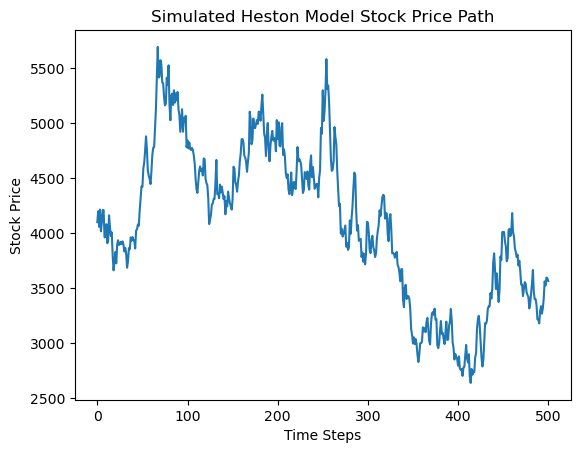

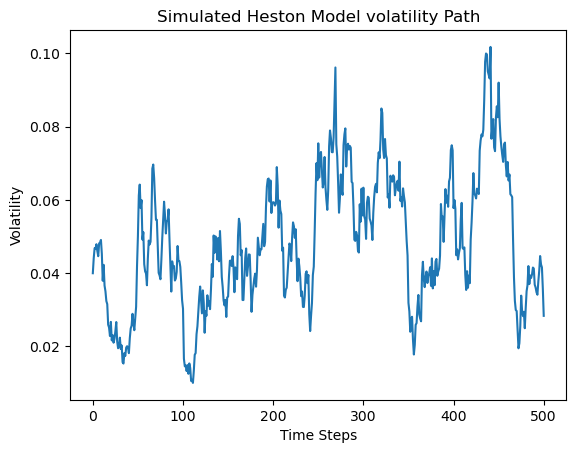

0.02


In [56]:
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 500
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

dt = T/N
print(dt)

In [57]:
print(params)

[0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]


In [58]:
mu = (0.01, 0.05)
kappa = (0.5, 3)
theta = (0.02, 0.2)
lambda_ = (0.01, 0.91)
rho = (-0.5, 1)
v_0 = params[-1]

params_0 = np.array([[mu, kappa, theta, lambda_, rho, v_0]])
params_0 =[mu, kappa, theta, lambda_, rho, v_0]

In [59]:
v, v_bis, param_steps, obs = particle_filter(params_0, N)

[(0.01, 0.05), (0.5, 3), (0.02, 0.2), (0.01, 0.91), (-0.5, 1)]
500
Done with iter: 1
resampling since: 299.65124923322196
Done with iter: 2
Done with iter: 3
resampling since: 224.17592717750986
Done with iter: 4
Done with iter: 5
Done with iter: 6
resampling since: 288.2083822905698
Done with iter: 7
resampling since: 233.23578656031606
Done with iter: 8
Done with iter: 9
resampling since: 190.58776647051644
Done with iter: 10
resampling since: 1.0
Done with iter: 11
resampling since: 86.56518871142659
Done with iter: 12
resampling since: 2.8553096805013936
Done with iter: 13
resampling since: 3.9174565996138933
Done with iter: 14
resampling since: 1.4097737607293568
Done with iter: 15
resampling since: 108.64712986866269
Done with iter: 16
resampling since: 7.6257916131399295
Done with iter: 17
resampling since: 27.978423058240885
Done with iter: 18
resampling since: 32.921268586680426
Done with iter: 19
resampling since: 9.155966611775819
Done with iter: 20
resampling since: 40.3738

Done with iter: 150
resampling since: 13.268654848363955
Done with iter: 151
resampling since: 207.9921651845403
Done with iter: 152
resampling since: 212.64836715058826
Done with iter: 153
resampling since: 196.33548587815628
Done with iter: 154
resampling since: 72.22750973794145
Done with iter: 155
resampling since: 103.43507187642196
Done with iter: 156
resampling since: 1.118824663795506
Done with iter: 157
resampling since: 5.224874008853429
Done with iter: 158
resampling since: 60.22166665343095
Done with iter: 159
resampling since: 10.094197313836128
Done with iter: 160
resampling since: 203.3158871272796
Done with iter: 161
resampling since: 273.20245816867396
Done with iter: 162
resampling since: 98.59880941497352
Done with iter: 163
resampling since: 222.7210966565014
Done with iter: 164
resampling since: 153.15252035440426
Done with iter: 165
resampling since: 127.4155430009121
Done with iter: 166
resampling since: 168.329209009366
Done with iter: 167
resampling since: 191.

resampling since: 51.94894962381629
Done with iter: 297
resampling since: 103.52845674621446
Done with iter: 298
resampling since: 5.365200764807915
Done with iter: 299
resampling since: 13.778589318404963
Done with iter: 300
resampling since: 1.527031401317643
Done with iter: 301
resampling since: 8.61916045886768
Done with iter: 302
resampling since: 70.40495042313977
Done with iter: 303
resampling since: 1.5459463081746574
Done with iter: 304
resampling since: 241.1233073384345
Done with iter: 305
resampling since: 115.62221381410396
Done with iter: 306
resampling since: 231.8128486814151
Done with iter: 307
resampling since: 233.22485285389018
Done with iter: 308
resampling since: 270.86668892927156
Done with iter: 309
resampling since: 3.3855863681931884
Done with iter: 310
resampling since: 277.2917827931407
Done with iter: 311
resampling since: 146.46381307647695
Done with iter: 312
resampling since: 142.50041786493668
Done with iter: 313
resampling since: 32.7006715918851
Done 

Done with iter: 442
resampling since: 70.5159051067805
Done with iter: 443
resampling since: 79.06915048398326
Done with iter: 444
resampling since: 9.26210861118825
Done with iter: 445
resampling since: 3.746715288464885
Done with iter: 446
resampling since: 14.126062599271728
Done with iter: 447
resampling since: 206.96648878806062
Done with iter: 448
resampling since: 6.256333187701527
Done with iter: 449
resampling since: 108.02366514572108
Done with iter: 450
resampling since: 24.266024064790734
Done with iter: 451
resampling since: 137.47181615314298
Done with iter: 452
resampling since: 148.48397642284286
Done with iter: 453
resampling since: 41.614320335600205
Done with iter: 454
resampling since: 304.76229648361294
Done with iter: 455
resampling since: 30.18373034329311
Done with iter: 456
resampling since: 231.11759610096672
Done with iter: 457
resampling since: 129.81668938259585
Done with iter: 458
resampling since: 152.3072698606032
Done with iter: 459
resampling since: 16

In [15]:
v, v_bis, param_steps, obs = particle_filter_2(params_0, y, N)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (500,) and arg 1 with shape (2,).

### 2.3 Plotting the results:

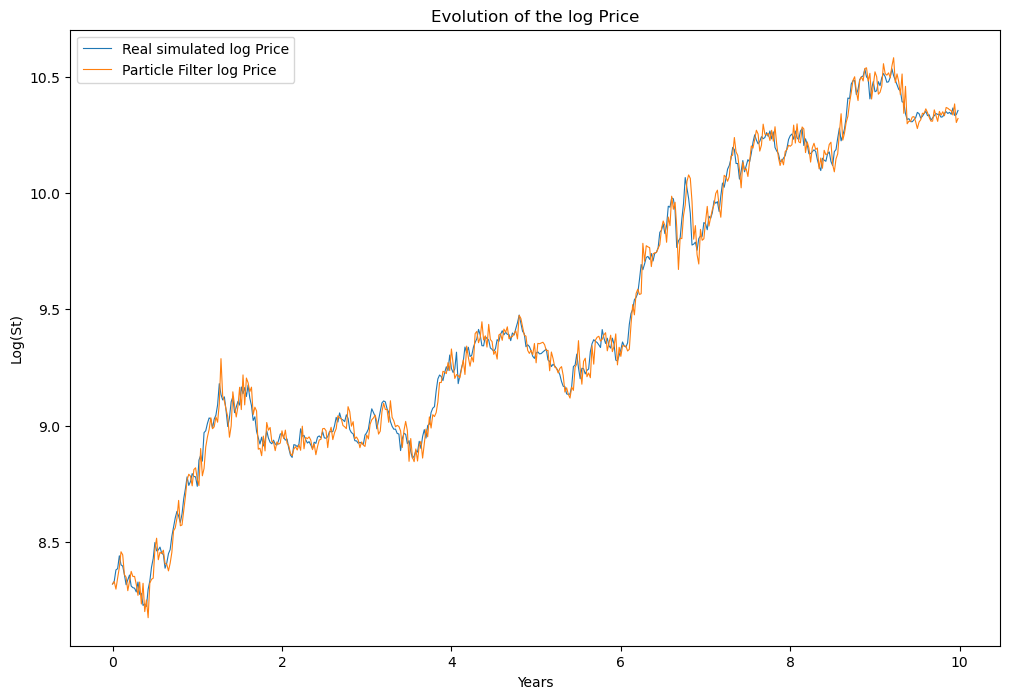

In [224]:
plt.figure(figsize=(12,8))
years = np.arange(obs.shape[-1]) * (T/N)
plt.plot(years, y[:-1], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years, obs, label = 'Particle Filter log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.legend()
plt.show()

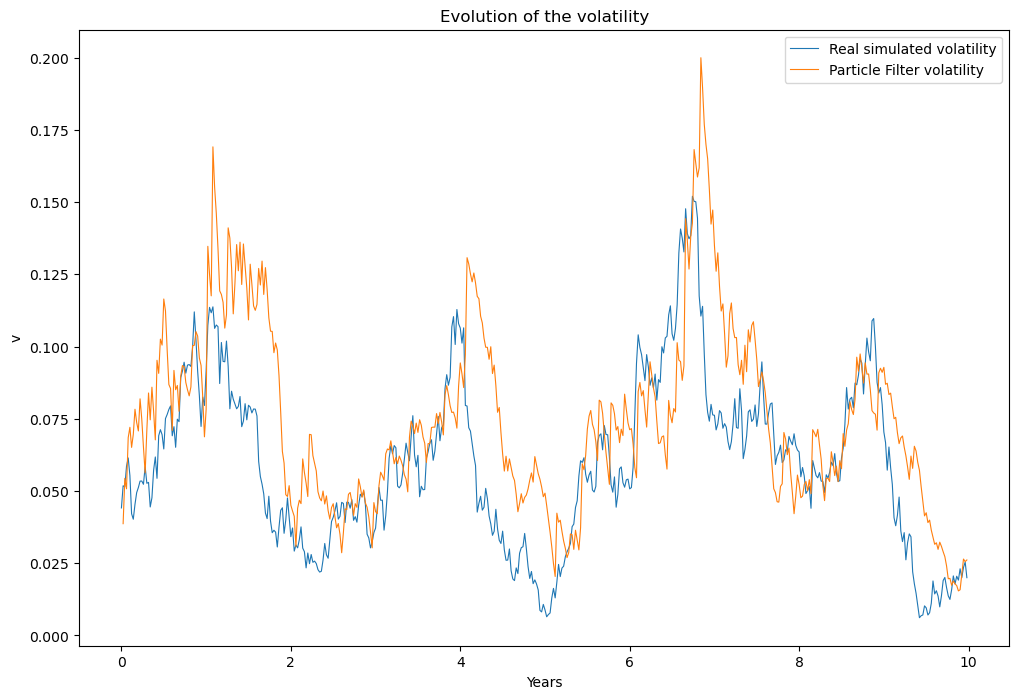

In [225]:
plt.figure(figsize=(12,8))
years = np.arange(v.shape[-1]) * (T/N)
plt.plot(years, v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v[1:], label = 'Particle Filter volatility', linewidth=0.8)
#plt.plot(years[1:], v_bis[1:], label = 'Particle Filter volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.legend()
plt.show()